In [1]:
import findspark
findspark.init()
import pyspark as spark
from pyspark.sql.functions import udf, col
import pyspark.sql.functions as F
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from hsbmpy import get_max_available_L
from hsbmpy import get_file
import tensorflow as tf

In [ ]:
import importlib, geneontology
from geneontology import *
importlib.reload(geneontology)
from geneontology import *

In [2]:
conf = spark.SparkConf().set('spark.driver.host','127.0.0.1')
sc = spark.SparkContext(master='local', appName='hSBM_topic-dist',conf=conf)
sql = spark.SQLContext(sc)

In [8]:
label='SMTS'
labels = ['SMTS']
#labels = ['primary_site', 'secondary_site']
algorithm = 'topsbm'
#labels = ['primary_site', 'secondary_site', 'status']
#labels=['RPPA Clusters']
directory = "/home/fvalle/phd/datasets/cancers/lung/"
L=get_max_available_L(directory, algorithm)-1
os.chdir(directory)

In [9]:
df_Pwt = sql.read.option('header',True).csv("%s/%s/%s_level_%d_word-dist.csv"%(directory,algorithm,algorithm,L))

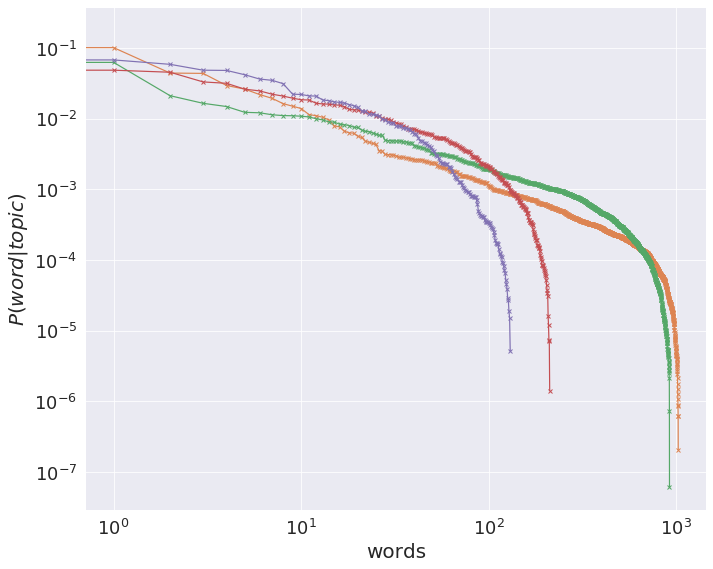

In [10]:
fig=plt.figure(figsize=(10,8))
plt.title("")
for topic in df_Pwt.columns[:5]:
    dist = df_Pwt.select([topic]).filter(F.col(topic)>1e-50).sort([topic], ascending=False).toPandas().astype(float).values
    if len(dist)<2:
        pass
    plt.plot(np.sort(dist[dist>0].T)[::-1], marker='x', label=topic)
plt.ylabel("$P(word | topic)$", fontsize=20)
plt.xlabel("words", fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=18)
#plt.legend()
plt.show()
fig.savefig("p_w_tw_%s.pdf"%algorithm)

In [11]:
df_Ptd = sql.read.option('header',True).csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm,algorithm,L)).drop('i_doc')

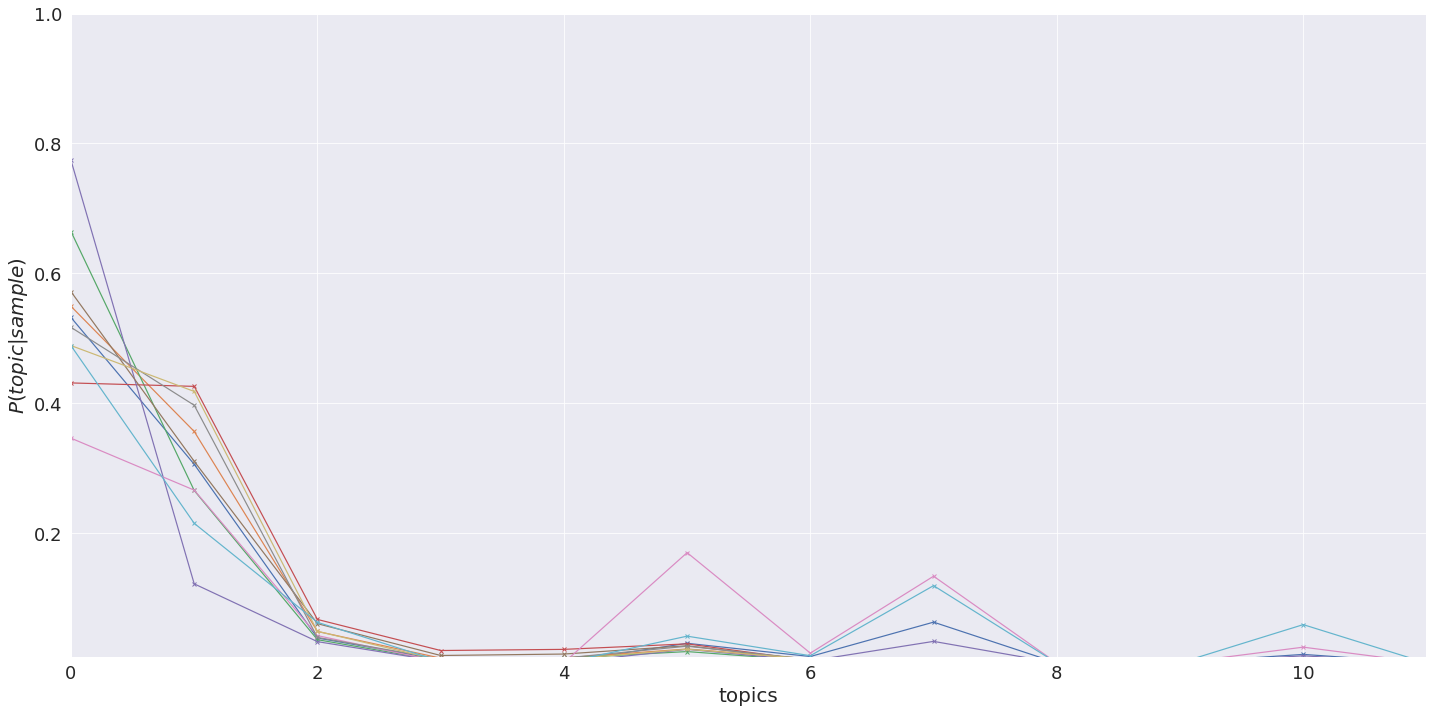

In [12]:
fig=plt.figure(figsize=(20,10))
plt.ylabel("$P(topic | sample$)", fontsize=20)
plt.xlabel("topics", fontsize=20)
for sample in df_Ptd.select('doc').toPandas().values[:10]:
    plt.plot(df_Ptd.filter(F.col('doc')==sample[0]).drop('doc').toPandas().astype(float).values[0], marker='x')
    #plt.plot(np.sort(df_Ptd.filter(F.col('doc')==sample[0]).drop('doc').toPandas().astype(float).values[0])[::-1], lw=0.1, marker='x')
#plt.plot(np.logspace(0,2),1/np.logspace(0,2))
#plt.xscale('log')
#plt.yscale('log')
plt.ylim(1e-2,1)
plt.xlim(0,len(df_Ptd.columns)-2)
plt.tick_params(labelsize=18)
plt.show()
fig.savefig("p_t_s_%s.pdf"%algorithm)

In [24]:
df_mt = pd.read_csv("mainTable.csv",index_col=0)
df_files=pd.read_csv("files.dat", index_col=0)
df_mt=df_mt.reindex(index=df_Pwt.select('_c0').toPandas().values.ravel(),
                    columns=[get_file(sample, df_files).name for sample in df_Ptd.select('doc').toPandas().values.ravel()])
#df_mt.dropna(inplace=True)
#df_mt=df_mt.where(df_mt<1e4,1e4)
df_mt.head()

,86a373e8-40a9-45b5-a646-6098bc88640e.FPKM.txt.gz,7e45a7f3-2613-498c-aa3b-d8cdc5001386.FPKM.txt.gz,631f56be-6fde-4e67-8ce1-83f01325d489.FPKM.txt.gz,a24d07c0-9b91-4538-96d2-f97544f4dbb0.FPKM.txt.gz,cea0635c-ac68-4712-937e-56ba8abca332.FPKM.txt.gz,06b1bbf5-07e5-4a03-aea1-f7203bab2572.FPKM.txt.gz,c5f18a05-b05e-4419-ab3f-b52784fc4ce3.FPKM.txt.gz,cd1665ab-4599-49b1-9d3d-b106dfbf8bcc.FPKM.txt.gz,fc2fcb44-c5cb-4b1a-822d-552f32866fe3.FPKM.txt.gz,8377d811-2636-4a75-be84-8e201ca646c1.FPKM.txt.gz,...,79caf319-b6a9-4e02-aede-444242d215d4.FPKM.txt.gz,7975e611-5e6d-444e-a773-5e131734a1ec.FPKM.txt.gz,cd068064-b4cc-4a34-94be-ce95e3342c6d.FPKM.txt.gz,bfcc0178-87a0-481d-b694-eb429fdfbaf4.FPKM.txt.gz,39a335c9-018d-46c9-a966-bbec6d1f19cb.FPKM.txt.gz,22c44a19-4cbb-4950-acf5-8d23a3fcb0a7.FPKM.txt.gz,783a2365-c4a2-4db4-ab14-d52e603d8230.FPKM.txt.gz,c622f68c-e37c-45ee-a266-ae704629f0f6.FPKM.txt.gz,a1231612-345f-4ff4-8ee9-c5e596357f76.FPKM.txt.gz,022cbd07-3e20-4144-b2ab-8c76adffae73.FPKM.txt.gz
0,,,,,,,,,,,,,,,,,,,,,
ENSG00000000938,6.91,43.13,35.29,0.89,7.38,3.62,1.45,28.75,23.99,1.83,...,1.77,4.99,2.82,72.22,2.39,8.71,22.62,12.22,2.48,7.02
ENSG00000000971,9.95,12.06,11.13,25.60,7.47,5.59,12.15,8.85,6.06,8.73,...,38.99,11.66,16.27,5.21,1.18,6.51,10.32,14.44,4.25,18.45
ENSG00000001084,23.89,10.33,2.15,0.33,57.56,12.99,18.00,1.89,2.79,81.46,...,2.11,7.84,15.93,5.34,20.12,4.44,1.34,17.58,120.07,6.17
ENSG00000001617,26.36,7.17,7.18,4.41,6.62,4.05,23.60,6.02,7.29,13.57,...,8.59,20.82,22.10,6.05,14.18,6.94,12.09,22.26,5.89,3.86
ENSG00000002933,13.31,8.00,18.59,49.48,25.99,7.11,2.89,7.24,7.54,6.10,...,3.18,18.71,4.33,7.24,5.46,20.62,15.97,17.44,63.84,9.87


In [25]:
Pgt = tf.convert_to_tensor(df_Pwt.toPandas().set_index('_c0').astype(float).values)
Pts = tf.transpose(tf.convert_to_tensor(df_Ptd.toPandas().set_index('doc').astype(float).values))
Pgs = tf.matmul(Pgt,Pts)
Ps = tf.convert_to_tensor(df_mt.sum(0).values)
Ps = tf.divide(Ps, tf.reduce_sum(Ps))#normalize
Pg = tf.squeeze(tf.matmul(Pgs, tf.reshape(Ps,[Ps.shape[0],1])))

In [26]:
print(Pgt.shape,Pts.shape,Pgs.shape,Pg.shape, Ps.shape)

(3000, 12) (12, 1145) (3000, 1145) (3000,) (1145,)


In [27]:
Pgs_data = Pgs.numpy()
Pg_data = Pg.numpy()
Pgs_data.shape

(3000, 1145)

In [28]:
df_Pgs = pd.DataFrame(data=Pgs_data, index=df_Pwt.toPandas().values.T[0], columns=df_Ptd.select(['doc']).toPandas().values.T[0])

In [29]:
A=df_mt.astype(int).sum(1).values

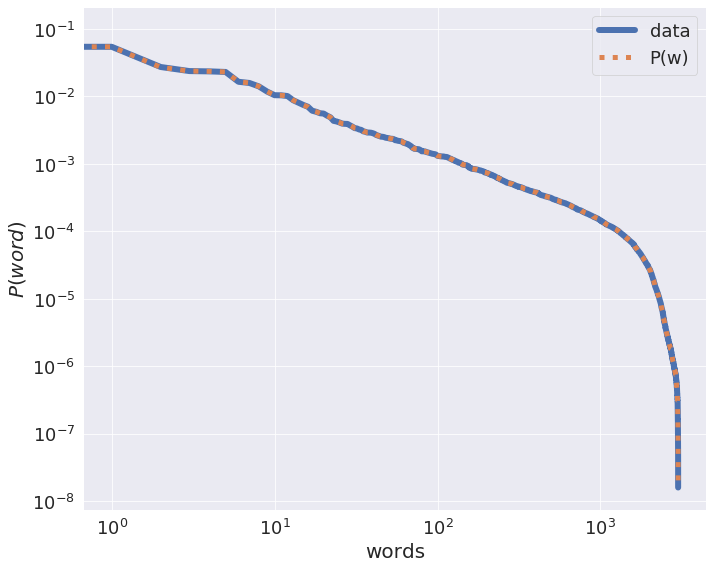

In [30]:
fig=plt.figure(figsize=(10,8))
plt.plot(np.sort(A)[::-1]/A.sum(), lw=6, ls='-', label='data')
plt.plot(np.sort(Pg_data)[::-1]/np.sum(Pg_data), lw=5, ls=':', label='P(w)')
plt.ylabel("$P(word$)", fontsize=20)
plt.xlabel("words", fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=18)
plt.legend(fontsize=18)
plt.show()
fig.savefig("p_w_%s.pdf"%algorithm)

In [31]:
A_lda=Pg_data

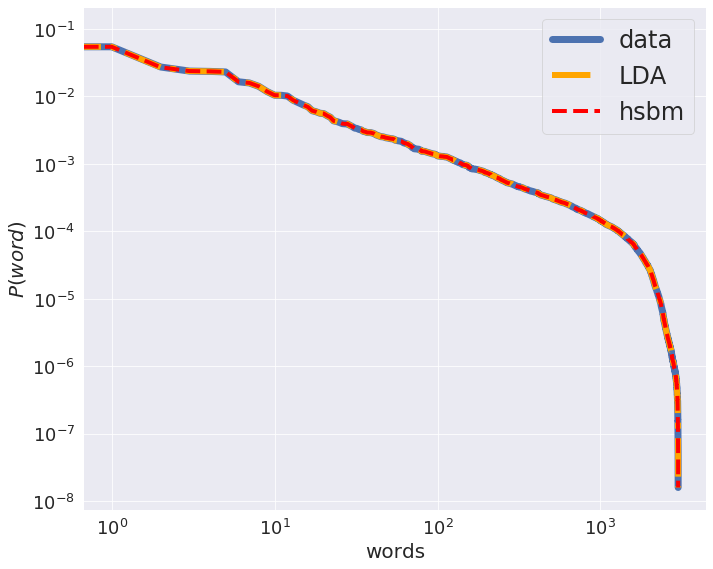

In [32]:
fig=plt.figure(figsize=(10,8))
plt.plot(np.sort(A)[::-1]/A.sum(), lw=7, ls='-', label='data')
plt.plot(np.sort(A_lda)[::-1]/np.sum(A_lda), lw=6, ls='-.', c='orange', label='LDA')
plt.plot(np.sort(Pg_data)[::-1]/np.sum(Pg_data), lw=4, ls='--', c='red', label='hsbm')
plt.ylabel("$P(word$)", fontsize=20)
plt.xlabel("words", fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=18)
plt.legend(fontsize=24)
plt.show()
fig.savefig("p_w.pdf")